Epoch 1, Train Loss: 2.1797, Validation Loss: 2.0207
Epoch 2, Train Loss: 1.9974, Validation Loss: 1.8867
Epoch 3, Train Loss: 1.9158, Validation Loss: 1.7924
Epoch 4, Train Loss: 1.8516, Validation Loss: 1.7106
Epoch 5, Train Loss: 1.8134, Validation Loss: 1.6691
Epoch 6, Train Loss: 1.7395, Validation Loss: 1.5803
Epoch 7, Train Loss: 1.7091, Validation Loss: 1.5473
Epoch 8, Train Loss: 1.6819, Validation Loss: 1.5517
Epoch 9, Train Loss: 1.6392, Validation Loss: 1.4772
Epoch 10, Train Loss: 1.6166, Validation Loss: 1.4945
Epoch 11, Train Loss: 1.5920, Validation Loss: 1.4731
Epoch 12, Train Loss: 1.5747, Validation Loss: 1.4178
Epoch 13, Train Loss: 1.5504, Validation Loss: 1.4156
Epoch 14, Train Loss: 1.5144, Validation Loss: 1.4286
Epoch 15, Train Loss: 1.5338, Validation Loss: 1.4140
Epoch 16, Train Loss: 1.4954, Validation Loss: 1.4268
Epoch 17, Train Loss: 1.4846, Validation Loss: 1.3544
Epoch 18, Train Loss: 1.4713, Validation Loss: 1.3536
Epoch 19, Train Loss: 1.4179, Validat

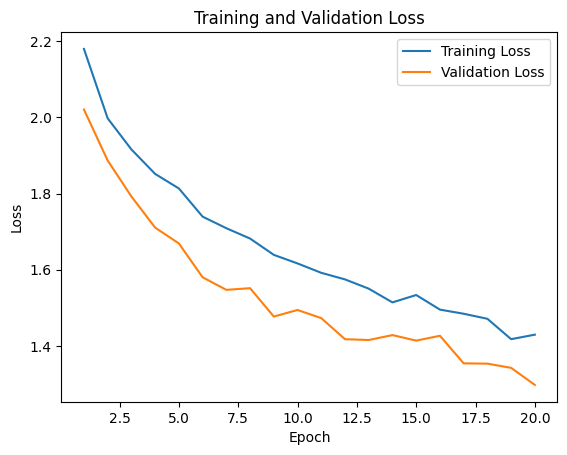

Test Accuracy: 52.16%
Confusion Matrix:\n [[ 52   6  11   3   1   8  15   0   0]
 [  3  47   3   0   3   0  14   0  21]
 [  8   0  44   7   0   0  30   0   1]
 [  2   3  13  73   1   3  51   1   0]
 [  2   7   2   9  12   2  52   9  22]
 [ 15   0   4  16   3  43  14   0   1]
 [  6   3   8   8   3   4 132   4   0]
 [  1   2   3  13   3   3  22  22   4]
 [  0   2   0   0   0   0   0   0  71]]
Classification Report:\n                      precision    recall  f1-score   support

          Cardboard       0.58      0.54      0.56        96
      Food Organics       0.67      0.52      0.58        91
              Glass       0.50      0.49      0.49        90
              Metal       0.57      0.50      0.53       147
Miscellaneous Trash       0.46      0.10      0.17       117
              Paper       0.68      0.45      0.54        96
            Plastic       0.40      0.79      0.53       168
      Textile Trash       0.61      0.30      0.40        73
         Vegetation       0.59 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation with Random transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
data_dir = "./RealWaste"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

# Split dataset
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN Model with weight initialization
class RealWasteNet(nn.Module):
    def __init__(self):
        super(RealWasteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(class_names))  # Number of classes
        self.dropout = nn.Dropout(0.5)

        # Weight Initialization
        self.apply(self.weights_init)

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize model, loss function, and optimizer
model = RealWasteNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Reduce learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop with early stopping
n_epochs = 20
train_loss_list, val_loss_list = [], []
best_val_loss = float('inf')
early_stopping_patience = 5
no_improvement_count = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    scheduler.step(val_loss)

# Plot training and validation loss
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Test the model
model.eval()
true_labels, predicted_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {test_accuracy:.2%}")

conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Confusion Matrix:\\n", conf_matrix)
print("Classification Report:\\n", class_report)
